In [1]:
import dask.dataframe as dd
from IPython.display import display
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import binary_dilation
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
def log_func(x, a, b, c):
    return a * np.log(x + b) + c

In [2]:
def analyze_matrix(ddf, pickle_data):
    matrix = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
    matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
    def process_resource(i, ddf2, resource_value):
        local_matrix = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
        local_matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2])))
        for j, bacteria_value in enumerate(pickle_data['param_values_list_combination'][1]):
            for k, phage_value in enumerate(pickle_data['param_values_list_combination'][2]):
                simulation_results = ddf2.query(f"Phages == {phage_value} and Uninfected_Bacteria == {bacteria_value} and Resources == {resource_value}").compute()
                y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[-1, :]
                if np.any(y_values > phage_value * 2):
                    local_matrix[j, k] = np.max(y_values)
                    local_matrix2[j, k] = 1
        return local_matrix, local_matrix2

    results = Parallel(n_jobs=-1)(
        delayed(process_resource)(i, ddf, resource_value)
        for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
    )

    for i, (col, col2) in enumerate(results):
        matrix[i, :, :] = col
        matrix2[i, :, :] = col2
    matrix = matrix.T
    matrix2 = matrix2.T
    return matrix, matrix2

In [3]:
def create_plot(x_dim, y_dim, z_dim, matrix, pickle_data, save_fig=None):
    fig = plt.figure(figsize=(10, 6))
    voxels = np.zeros((x_dim, y_dim, z_dim), dtype=bool)
    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if matrix[i, j, k] > 0:
                    print(matrix[i, j, k])
                    voxels[i, j, k] = True
    colors = np.zeros(voxels.shape + (4,), dtype=float) 
    colors[voxels] = [1, 0, 0, 0.2] 
    colors[~voxels] = [1, 1, 1, 0]

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxels, facecolors=colors)
    ax.set_xlabel('Resources', fontsize=14)
    ax.set_ylabel('Bacteria', fontsize=14)
    ax.set_zlabel('Phages', fontsize=14)
    ax.set_title('Max Y Values For Phages If Proliferated \n Else 0 If Not Proliferated', fontsize=16)
    xtick_indices = np.arange(0, x_dim, 3)
    xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[xtick_indices]]
    ytick_indices = np.arange(0, y_dim, 3)
    ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[ytick_indices]]
    ztick_indices = np.arange(0, z_dim, 3)
    ztick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][2])[ztick_indices]]
    ax.set_xticks(xtick_indices)
    ax.set_xticklabels(xtick_labels, fontsize=12)
    ax.set_yticks(ytick_indices)
    ax.set_yticklabels(ytick_labels, fontsize=12)
    ax.set_zticks(ztick_indices)
    ax.set_zticklabels(ztick_labels, fontsize=12)
    plt.tight_layout()
    if save_fig is not None:
        plt.savefig(f'LatexReport/Images/Plots/Created/PP/{save_fig}', dpi=300, bbox_inches='tight')

    # Save to file
    plt.show()

parameter_names_used ['Resources', 'Uninfected Bacteria', 'Phages']
param_values_list_combination [[1.0, 36.642857142857146, 72.28571428571429, 107.92857142857144, 143.57142857142858, 179.21428571428572, 214.8571428571429, 250.50000000000003, 286.14285714285717, 321.78571428571433, 357.42857142857144, 393.0714285714286, 428.7142857142858, 464.3571428571429, 500.0], [1.0, 0.9285714285714286, 0.8571428571428572, 0.7857142857142857, 0.7142857142857143, 0.6428571428571429, 0.5714285714285714, 0.5, 0.4285714285714286, 0.3571428571428572, 0.2857142857142858, 0.2142857142857143, 0.1428571428571429, 0.07142857142857151, 0.0], [1.0, 4.5, 8.0, 11.5, 15.0, 18.5, 22.0, 25.5, 29.0, 32.5, 36.0, 39.5, 43.0, 46.5, 50.0]]
partition_data [1, 1, 4, 1]
agent_type ['Resources', 'Uninfected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Infected Bacteria', 'Phages']
agent_names ['R0', 'B0', 'Infected B0', 'Infected B1', 'Infected B2', 'Infected B3', 'P0']
2448.611327254309
4630.8

/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_20766/3166336690.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

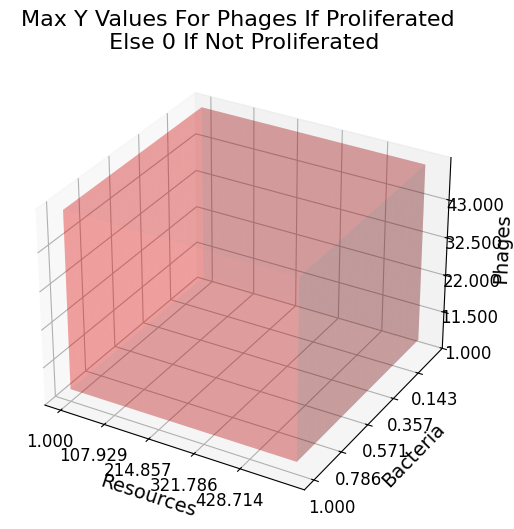

In [ ]:
parquet_file_path = 'SimulationResults/UltimateAnalysis/SimulationResults_1749082539/simulation_results_1749082539.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/SimulationResults_1749082539/simulation_results_1749082539.pickle'


with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

ddf = dd.read_parquet(parquet_file_path, engine='pyarrow', 
                      include_partition_columns=True, 
                      gather_statistics=True, 
                      dtype_backend='pyarrow')
ddf = ddf.rename(columns={'Uninfected Bacteria': 'Uninfected_Bacteria'})
# matrix, matrix2 = analyze_matrix(ddf, pickle_data)
create_plot(len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1]), len(pickle_data['param_values_list_combination'][2]), matrix, pickle_data)
